# import

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import statistics

#functions
def load_in_paths(pp_file, PP_PATH, DAT_PATH):
    mir = '_'.join(pp_file.split('_')[0:3])
    print(str(run_index+1) + '/' + str(len(os.listdir(PP_PATH))-1) + '-------------------------------------------------------------------------')
    print(pp_file)
    mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
    skip = False
    for item in ignore_list:
        if item == mouse_session_recording:
            skip = True

    save_path = PP_PATH + pp_file + '\\_final_analysis_output\\'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    for file_ in os.listdir(dat_path + r"\video\tracking\\"):
        if 'task' in file_:
            if not 'clock' in file_:
                tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
   
    return mir,mouse_session_recording,save_path,tracking_path,dat_path

def load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording):

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    ## LOAD 
    print("LOADING PPSEQ DATA")
    print('\n')
    #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
    assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

    # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
    latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

    # seq_type_log_proportions: log p of each type of sequence at each iteration
    seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

    # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
    # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
    neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")

    masking = False
    for dat_files in os.listdir(PP_PATH + pp_file):
        if 'unmasked_spikes' in dat_files:
            masking = True
            print('masking was used')

    if masking == True:
        #log_p_hist.csv: the history of the log_p of the model
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

        unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
    else:
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

        spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
        neuron_ids, spike_times= [], []
        with open(spikes_file) as f:
            for (i, line) in enumerate(f.readlines()):
                neuron_id, spike_time = line.split('\t')
                spike_time = float(spike_time.strip())
                neuron_id = float(neuron_id)
                spike_times.append(spike_time)
                neuron_ids.append(neuron_id)
        unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 
        bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")

    # Opening JSON file
    f = open(PP_PATH + pp_file + r'\config_file.json')
    # returns JSON object as a dictionary
    config = eval(json.load(f))
    print(f'      done')

    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")

    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as 
    # a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span']
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

    ### load in data:
    for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
        if 'task' in sub_file:
            behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
    behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

    return assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start

def plot_save_log_l_curve(log_p_hist_df,save_path):
    # find 95% of growth value and when it crossed this
    max_ = max(log_p_hist_df.x1)
    min_ = min(log_p_hist_df.x1)
    growth = max_ - min_
    _prcntile =  max_ - (0.02 * growth)

    ## model log likley hood curve
    plt.plot(log_p_hist_df.x1)
    plt.axhline(y=_prcntile, color='r', linestyle='--')

    SaveFig('log_l_curve.png',save_path)

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
#     plt.show()
    plt.close()

def plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, save_path):
    # calculate interval timings and end points
    interval_lengths = []
    for interval in behav_time_interval_start:
        interval_lengths += [np.diff(interval)[0]]
    total_time = sum(interval_lengths)
    interval_end_points = np.cumsum(interval_lengths)

    # Plot sequences - basic
    timeframe = [0, total_time]
    mask = (spikes_df.timestamp > timeframe[0]) * (spikes_df.timestamp < timeframe[-1])

    # Define neuron order
    neuron_permute_loc = np.zeros(len(neuron_index))
    for i in range(len(neuron_index)):
        neuron_permute_loc[i] = int(list(neuron_index).index(i))
    neuron_order = neuron_permute_loc[(spikes_df.neuron - 1).astype(int)]

    # Plotting
    fig, [ax, ax2] = plt.subplots(2, 1, figsize=(20, 20))

    # Plot background in grey
    background_keep_mask = (spikes_df[mask].sequence_type_adjusted < 0) | (spikes_df[mask].sequence_type_adjusted >= 7.0)
    ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
               marker='o', s=40, linewidth=0, color='lightgrey', alpha=0.3)
    c_ = np.array(colors)[spikes_df[mask][background_keep_mask].sequence_type_adjusted.values.astype(int)]
    ax2.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
                marker='o', s=40, linewidth=0, color=c_, alpha=0.3)
    ax2.set_title('extra sequences and background only')

    # Plot spikes without background
    background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0) * \
                             (spikes_df[mask].sequence_type_adjusted != 7.0) * \
                             (spikes_df[mask].sequence_type_adjusted != 8.0)
    c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],
               marker='o', s=40, linewidth=0, color=c_, alpha=1)
    ax.set_title('held sequences in color and extra sequences + background in grey')

    for end_p in interval_end_points:
        ax.axvline(x=end_p, color='k')

    # Save the figure
    plt.savefig(save_path)
    plt.show()
    return interval_end_points,neuron_order


def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def split_list(numbers):
    chunks = []
    indices = []
    current_chunk = []
    current_indices = []
    for i, num in enumerate(numbers):
        if num == 0:
            if current_chunk:
                chunks.append(current_chunk)
                indices.append(current_indices)
                current_chunk = []
                current_indices = []
        else:
            current_chunk.append(num)
            current_indices.append(i)
    if current_chunk:
        chunks.append(current_chunk)
        indices.append(current_indices)
    return chunks, indices

# Function to create directory if it doesn't exist
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)

# Function to save figure
def save_figure(fig, filename, path):
    fig.savefig(os.path.join(path, filename))

# Function to filter and save replay clusters
def filter_and_save_replay_clusters(chunk_df, chunk_path, r_seq_type, r_start_, r_end_, colors, min_spikes_filter, min_neurons_involved_filter):
    filtered_data = {
        'cluster_seq_type': [],
        'num_spikes': [],
        'num_neurons': [],
        'first_spike_time': [],
        'event_length': [],
        'last_spike_time': [],
        'cluster_spike_times': [],
        'cluster_neurons': [],
        'spike_plotting_order': []
    }

    for i in range(len(r_seq_type)):
        r_event_df = chunk_df[(chunk_df.timestamp >= r_start_[i]) & (chunk_df.timestamp <= r_end_[i])].copy()
        neuron_orders = neuron_order[chunk_mask][(chunk_df.timestamp >= r_start_[i]) & (chunk_df.timestamp <= r_end_[i])]
        neuron_orders = neuron_orders[r_event_df.sequence_type_adjusted == r_seq_type[i]]
        r_event_df = r_event_df[r_event_df.sequence_type_adjusted == r_seq_type[i]]

        if len(r_event_df) > 0:
            num_spikes = len(r_event_df.sequence_type_adjusted)
            num_neurons = len(r_event_df.neuron.unique())
            first_spike = min(r_event_df.timestamp)
            last_spike = max(r_event_df.timestamp)

            if num_spikes >= min_spikes_filter and num_neurons >= min_neurons_involved_filter:
                ax1.axvspan(first_spike, last_spike, color=colors[r_seq_type[i]], alpha=0.5)
                filtered_data['cluster_seq_type'].append(r_seq_type[i])
                filtered_data['num_spikes'].append(num_spikes)
                filtered_data['num_neurons'].append(num_neurons)
                filtered_data['first_spike_time'].append(first_spike)
                filtered_data['event_length'].append(last_spike - first_spike)
                filtered_data['last_spike_time'].append(last_spike)
                filtered_data['cluster_spike_times'].append(list(r_event_df.timestamp.values))
                filtered_data['cluster_neurons'].append(list(r_event_df.neuron.values))
                filtered_data['spike_plotting_order'].append(neuron_orders)

    filtered_r_clusters_df = pd.DataFrame(filtered_data)
    filtered_r_clusters_df.to_csv(os.path.join(chunk_path, 'filtered_replay_clusters_df.csv'), index=False)
    
    print('###################################')
    print('replay rate is')
    print(len(filtered_r_clusters_df) / 10)
    print('###################################')


# notes

1. i need to compare this to how many are found when running awake on awake without the shuffle...
2. I think I need to do the linear replay check with the regression...
3. i might need to make new data where i have sequences implanted into background - but the background is not shuffled noise but times when there are no sequneces occuring...ie. sythetic data but without the shuffled background noise. 



# load data and filter for events

In [2]:
ignore_list= []

# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\ppseq_output\\"
# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\ppseq_output_not_shuffled\\"#
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"

DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"


# PP_PATH = r"D:\\"

######################################################################################################################################################################################################################
# load in data, extract, filter PPseq spikes etc.
# main filtering here:
# backgroudn confidence - spike had to be classified as a seq type 75% of the time across the last 50 iterations to be kept.   
######################################################################################################################################################################################################################

for run_index,pp_file in enumerate(os.listdir(PP_PATH)[-2::]):
    
#     pp_file= '262_1_4_run_2106023_2357'
    
    if run_index >-1 and 'run' in pp_file:
        # load in paths for that specific mouse and recording
        mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH)
        
        ## load in PPseq output data
        assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording)
        # plot out log l curve 
        plot_save_log_l_curve(log_p_hist_df,save_path)
        
    # ---filter_across_itterations---------------------------------------------------------------------------------------------------------------------------------------------------------------    
        # Initialize an empty df to store the result
        seq_types_df = pd.DataFrame()
        # Iterate through the range
        # for iteration_ in tqdm(range(400, 500)):
        for iteration_ in tqdm(range(250, 300)):
            # Extract the relevant column from the assignment history dataframe
            assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]
            # Get the index of the -1 split markers in the latent event history dataframe
            end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
            # Extract the relevant portion of the latent event history dataframe
            latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]
            # Create a dictionary from the dataframe for faster lookups
            df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()
            # Match the sequence ID to the sequence type
            seq_type = find_corresponding(assignment_history_df_split)
            # Append the result to the df
            seq_types_df[str(iteration_+1)] = seq_type
        proportion = []
        seq_type = []
        for index in tqdm(range(len(seq_types_df))):
            row = seq_types_df.loc[index]
            seq_type += [statistics.mode(row)] 
            proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]
        # add seq type to dataframe
        unmasked_spikes_df['sequence_type'] = seq_type
        # add seq type to dataframe
        unmasked_spikes_df['seq_confidence'] = proportion
        
        # ## filter for background confidence :-------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        thresh = max(proportion) *.75 ### 
        plt.plot(np.sort(proportion)[::-1])
        plt.axhline(y = thresh, color = 'r', linestyle = '-')
        unmasked_spikes_df['sequence_type_adjusted'] = seq_type
        unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1
        SaveFig('filtering_curve.png',save_path)
        
        ## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
        for file_ in os.listdir(awake_PP_path):
            if mouse_session_recording in file_:
                awake_file = file_
        ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
        neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
        colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
        spikes_df = unmasked_spikes_df
        colors += ['pink','lightblue', 'k'] 
        
        ############### plot simple rasters ------------------------------
        interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, 'all_data_raster.png')
        
        
        # Constants
        min_spikes_filter = 5
        min_neurons_involved_filter = 3
        bin_size = 0.02

        # Main processing loop
        chunk_paths = []
        for index_, interval_start in enumerate([0] + list(interval_end_points)[:-1]):
            chunk_path = os.path.join(save_path, f'chunk{index_+1}_{behav_time_interval_start[index_][0]}to{behav_time_interval_start[index_][1]}\\')
            chunk_paths.append(chunk_path)
            create_directory(chunk_path)

            np.save(os.path.join(chunk_path, 'chunk_time_interval.npy'), np.array(behav_time_interval_start[index_]))

            timeframe = [interval_start, interval_end_points[index_] - 1]
            total_time = np.diff(timeframe)[0] + 1
            mask = (spikes_df.timestamp > timeframe[0]) & (spikes_df.timestamp < timeframe[-1])

            fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(35, 15))

            background_remove_mask = (spikes_df[mask].sequence_type_adjusted > -1) & (spikes_df[mask].sequence_type_adjusted < 7)
            c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
            ax1.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask], marker='o', s=40, linewidth=0, color=c_, alpha=1)

            chunk_mask = (spikes_df.timestamp > interval_start) & (spikes_df.timestamp < interval_end_points[index_])
            chunk_df = spikes_df[chunk_mask].copy().reset_index(drop=True)
            chunk_df.to_csv(os.path.join(chunk_path, 'unfiltered_spikes_data.csv'), index=False)

            seqs = np.unique(chunk_df.sequence_type_adjusted)
            seq_spikes = [chunk_df.timestamp[chunk_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]
            seq_neurons = [chunk_df.neuron[chunk_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]

            binned_seq_r_events = [np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))[0] for spikes_ in seq_spikes]

            strt_ = int(timeframe[0] / bin_size)
            end_ = int(timeframe[1] / bin_size)

            r_start_, r_end_, r_seq_type = [], [], []
            for _index_, sequence_type in enumerate(seqs):
                sequence_type = int(sequence_type)
                if 0 < sequence_type <= 6:
                    smoothed_binned_spikes = convolve_movmean(binned_seq_r_events[_index_], 2)
                    time_bins = np.arange(timeframe[0], timeframe[0] + np.diff(timeframe) + 1, bin_size)
                    ax2.plot(time_bins[:-1], smoothed_binned_spikes, c=colors[sequence_type])
                    ax2.sharex(ax1)

                    replay_chunks, indices = split_list(list(smoothed_binned_spikes))
                    for index, chunk in enumerate(replay_chunks):
                        r_seq_type.append(sequence_type)
                        r_start_.append(time_bins[indices[index][0]])
                        r_end_.append(time_bins[indices[index][-1]])

            filter_and_save_replay_clusters(chunk_df, chunk_path, r_seq_type, r_start_, r_end_, colors, min_spikes_filter, min_neurons_involved_filter)

            ax1.set_xlim(timeframe[0] + 140, timeframe[0] + 150)
            ax2.set_xlim(timeframe[0] + 140, timeframe[0] + 150)

            save_figure(fig, f'zoomed_data_filtering_chunk_{index_+1}.png', chunk_path)
            plt.close(fig)



FileNotFoundError: [WinError 53] The network path was not found: 'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\Reveiw_Pre_sleep\\\\'

# plots

In [40]:
# load in the shuffled data - extract number of sequenes found
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\ppseq_output\\"
shuffle_events_per_min = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file)+ r'//_final_analysis_output//'
    clust_events_per_min = 0
    all_chunks_len = 0
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
                # only sequential events
                clust_events_per_min += len(replay_clusts[replay_clusts.ordering_classification == 'sequential'])
                all_chunks_len += interval_length/60
    if all_chunks_len > 0:
        shuffle_events_per_min += [clust_events_per_min/all_chunks_len]


# load in the non shuffle - extract number of sequuences found 
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\circular_shuffle\ppseq_output_not_shuffled\\"
non_shuff_events_per_min = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file)+ r'//_final_analysis_output//'
    clust_events_per_min = 0
    all_chunks_len = 0
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
                # only sequential events
                clust_events_per_min += len(replay_clusts[replay_clusts.ordering_classification == 'sequential'])
                all_chunks_len += interval_length/60
    if all_chunks_len > 0:
        non_shuff_events_per_min += [clust_events_per_min/all_chunks_len]

100%|██████████| 13/13 [01:49<00:00,  8.44s/it]


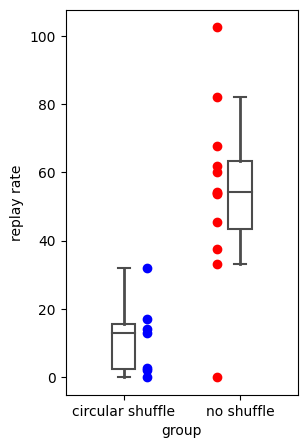

In [64]:
shuffle_events_per_min

non_shuff_events_per_min

import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(3, 5))

ax.plot([0.2]*len(shuffle_events_per_min),shuffle_events_per_min,'o', color = 'blue')
ax.plot([0.8]*len(non_shuff_events_per_min),non_shuff_events_per_min,'o', color = 'red')

plt_df = pd.DataFrame({'group': (['circular shuffle'] * len(shuffle_events_per_min)) + (['no shuffle'] * len(non_shuff_events_per_min)) , 'replay rate': list(shuffle_events_per_min)+list(non_shuff_events_per_min)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

# PRESLEEP ANALYSIS 

In [151]:

# load in the presleep data - extract number of sequenes found
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"
presleep_events_per_min = []
mirs = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file_ = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file_)+ r'//_final_analysis_output//'
    clust_events_per_min = 0
    all_chunks_len = 0
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                interval_length = int(file.split('_')[-1].split('to')[-1]) - int(file.split('_')[-1].split('to')[0])
                # only sequential events
                clust_events_per_min += len(replay_clusts[replay_clusts.ordering_classification == 'sequential'])
                all_chunks_len += interval_length/60
    if all_chunks_len > 0:
        presleep_events_per_min += [clust_events_per_min/all_chunks_len]
        mirs += [file_.split('_run')[0]]

post_sleep_replay_rates = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\replay_rate_old_data\replay_rates.csv")

100%|██████████| 31/31 [05:50<00:00, 11.32s/it]


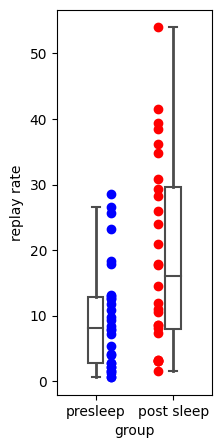

In [173]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

for epms in presleep_events_per_min:
    ax.plot(0.2,epms,'o', color = 'blue')
    
ps_rr = post_sleep_replay_rates.reactivations_per_min.values   
ax.plot([0.8]*len(ps_rr),ps_rr,'o', color = 'red')

plt_df = pd.DataFrame({'group': (['presleep'] * len(presleep_events_per_min)) + (['post sleep'] * len(ps_rr)) , 'replay rate': list(presleep_events_per_min)+list(ps_rr)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

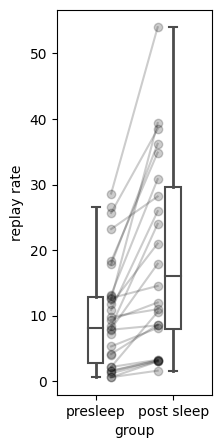

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
for index, mir in enumerate(mirs):
    pre_events = presleep_events_per_min[index]
    if mir in post_sleep_replay_rates.mirs.values:
        post_events = post_sleep_replay_rates[post_sleep_replay_rates.mirs == mir].reactivations_per_min.values[0]
        ax.plot([0.2,0.8],[pre_events,post_events],'o-', color = 'k', alpha = 0.2)
        
plt_df = pd.DataFrame({'group': (['presleep'] * len(presleep_events_per_min)) + (['post sleep'] * len(ps_rr)) , 'replay rate': list(presleep_events_per_min)+list(ps_rr)})
ax = sns.boxplot(y='replay rate', x='group', data=plt_df, color='blue', width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

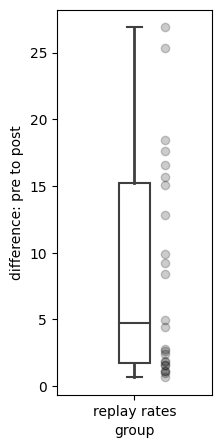

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
diffs = []
for index, mir in enumerate(mirs):
    pre_events = presleep_events_per_min[index]
    if mir in post_sleep_replay_rates.mirs.values:
        post_events = post_sleep_replay_rates[post_sleep_replay_rates.mirs == mir].reactivations_per_min.values[0]
        diff = post_events - pre_events
        diffs += [diff]
        ax.plot([0.2],diff,'o', color = 'k', alpha = 0.2)
        
plt_df = pd.DataFrame({'group': (['replay rates'] * len(diffs)), 'difference: pre to post': diffs})
ax = sns.boxplot(y='difference: pre to post', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')


# preprocess event details

In [257]:
from ast import literal_eval

PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\\"

# PP_PATH =  r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
number_of_spikes = []
event_lengths = []
number_of_neurons = []
mirs = []
for iteration_ in tqdm(range(len(os.listdir(PP_PATH)))):
    file_ = os.listdir(PP_PATH)[iteration_]
    data_path = os.path.join(PP_PATH,file_)+ r'//_final_analysis_output//'
    chunk_number_of_spikes = []
    chunk_event_lengths = []
    chunk_number_of_neurons = []
    for file in os.listdir(data_path):
        if 'chunk' in file:
            current_data_path = os.path.join(data_path,file)+ r'//'
            replay_clusts = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            if 'ordering_classification' in list(replay_clusts):
                filtered_replay_clusts = replay_clusts[replay_clusts.ordering_classification == 'sequential']
                chunk_number_of_spikes += [list(filtered_replay_clusts.num_spikes.values)]
                chunk_event_lengths += [list(filtered_replay_clusts.event_length.values)]
                n_neurons = []
                for clusters in filtered_replay_clusts.cluster_neurons:
                    n_neurons += [len(np.unique(literal_eval(clusters)))]
                chunk_number_of_neurons += [n_neurons]
                
    mirs += [file_.split('_run')[0]]
    number_of_spikes += [chunk_number_of_spikes]
    event_lengths += [chunk_event_lengths]
    number_of_neurons += [chunk_number_of_neurons]  
    
out_df = pd.DataFrame({'mirs':mirs,'number_of_spikes_per_event_per_chunk':number_of_spikes,'event_lengths_per_event_per_chunk':event_lengths,'number_of_neurons_per_event_per_chunk':number_of_neurons}) 
out_df.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv",index = False)

100%|██████████| 31/31 [05:48<00:00, 11.25s/it]


# load and plot

In [279]:
postsleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\postsleep_event_details.csv")
presleep_event_details = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\presleep_event_details.csv")


c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


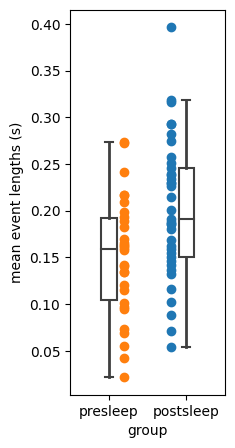

In [280]:
mean_neurons = []
for item in postsleep_event_details.event_lengths_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.event_lengths_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'mean event lengths (s)': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='mean event lengths (s)', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


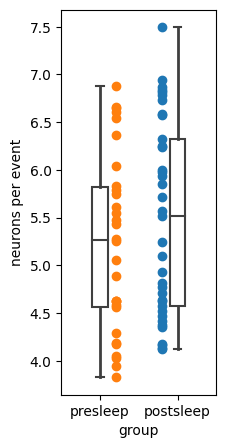

In [281]:
mean_neurons = []
for item in postsleep_event_details.number_of_neurons_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.number_of_neurons_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'neurons per event': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='neurons per event', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


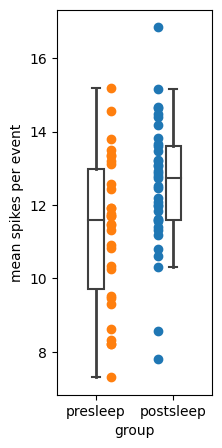

In [282]:
mean_neurons = []
for item in postsleep_event_details.number_of_spikes_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    mean_neurons += [np.mean(flattened_list)]
    
pre_mean_neurons = []
for item in presleep_event_details.number_of_spikes_per_event_per_chunk:    
    flattened_list = [item for sublist in literal_eval(item) for item in sublist]
    pre_mean_neurons += [np.mean(flattened_list)]
    
fig, ax = plt.subplots(1, 1, figsize=(2, 5))

ax.plot([0.8] * len(mean_neurons),mean_neurons,'o')
ax.plot([0.2] * len(pre_mean_neurons),pre_mean_neurons,'o')

plt_df = pd.DataFrame({'group': (['presleep'] * len(pre_mean_neurons))+(['postsleep'] * len(mean_neurons)), 'mean spikes per event': pre_mean_neurons+mean_neurons})
ax = sns.boxplot(y='mean spikes per event', x='group', data=plt_df, width=.2, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

In [ ]:
# is this significant?
# firing rate differences? 


In [236]:
chunk_item

']'

In [232]:
presleep_event_details

,mirs,number_of_spikes_per_event_per_chunk,event_lengths_per_event_per_chunk,number_of_neurons_per_event_per_chunk
0,136_1_3,"[array([17, 10, 14, 12, 9, 20, 13, 12, 18, 9...","[array([0.0616, 0.0912, 0.0432, 0.0789, 0.0074...","[[8, 4, 6, 6, 4, 7, 8, 5, 10, 5, 5, 10, 10, 4,..."
1,136_1_4,"[array([ 9, 7, 7, 5, 5, 8, 22, 12, 11, 5...","[array([0.0637, 0.0412, 0.0262, 0.0576, 0.069 ...","[[4, 3, 5, 3, 5, 4, 7, 8, 4, 3, 4, 10, 3, 4, 4..."
2,149_1_1,"[array([ 6, 45, 32, 8, 6, 9, 10, 6, 8, 6...","[array([8.200e-03, 9.190e-02, 6.460e-02, 8.000...","[[3, 3, 11, 4, 4, 4, 3, 4, 7, 3, 4, 4, 3, 7, 4..."
3,178_1_4,"[array([15, 67, 16, 10, 9, 14, 13, 18, 7, 7...","[array([0.0591, 0.3819, 0.043 , 0.054 , 0.0327...","[[4, 16, 6, 4, 4, 6, 5, 6, 4, 4, 12, 6, 3, 3, ..."
4,178_1_6,"[array([11, 18, 9, 6, 11, 14, 5, 16, 12, 10...","[array([0.0592, 0.1331, 0.1322, 0.033 , 0.1113...","[[8, 8, 5, 3, 5, 7, 3, 7, 4, 7, 7, 4, 6, 4, 8,..."
5,178_1_7,"[array([ 6, 9, 12, 9, 10, 6, 6, 7, 21, 24...","[array([0.0087, 0.0556, 0.0393, 0.0652, 0.0549...","[[5, 4, 6, 4, 4, 5, 5, 4, 12, 14, 8, 4, 7, 8, ..."
6,178_1_8,[],[],[]
7,178_1_9,"[array([], dtype=object), array([20, 7, 11, ...","[array([], dtype=object), array([0.1248, 0.488...","[[], [9, 4, 6, 5, 9, 8, 8, 8, 8, 4, 4, 9, 5, 8..."
8,178_2_1,"[array([ 13, 6, 6, 13, 22, 6, 34, 9...","[array([0.1458, 0.0251, 0.0342, 0.0389, 0.184 ...","[[7, 4, 5, 7, 8, 3, 11, 5, 8, 5, 6, 10, 10, 3,..."
9,178_2_2,"[array([ 9, 14, 10, 16, 12, 5, 13, 11, 10, 8...","[array([1.739e-01, 1.415e-01, 1.031e-01, 1.861...","[[5, 3, 5, 3, 6, 5, 4, 6, 5, 6, 3, 4, 4, 16, 6..."


In [229]:
  
out_df = pd.DataFrame({'mirs':mirs,'number_of_spikes_per_event_per_chunk':number_of_spikes,'event_lengths_per_event_per_chunk':event_lengths,'number_of_neurons_per_event_per_chunk':number_of_neurons}) 
out_df.to_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\pre_sleep_processed_data\postsleep_event_details.csv",index = False)

In [ ]:
# presleep 
# event lengths?
# number of neurons per event?
# types of event? sequence distribution 